<a href="https://colab.research.google.com/github/hadisotudeh/zestyAI_challenge/blob/main/Zesty_AI_Data_Scientist_Assignment_%7C_Hadi_Sotudeh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1><b>Zesty AI Data Science Interview Task - Hadi Sotudeh</b></h1> </center>

To perform this task, I had access to the [`2009 RESIDENTIAL ENERGY CONSUMPTION SURVEY`](https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata) to predict `electricity consumption`.
</br>
</br>
Libraries available in Python such as `scikit-learn` and `fastai` were employed to perform this machine learning regression task.
</br>
</br>
First, I need to install the notebook dependencies, import the relevant libraries, download the dataset, and have them available in Google Colab (next cell).

## Install Dependencies, Import Libraries, and Download the dataset

In [1]:
%%capture

# install dependencies
!pip install fastai --upgrade

In [2]:
# Import Libraries

# general libraries
import warnings
import os
from datetime import datetime
from tqdm import tqdm_notebook as tqdm

# machine learning libraries
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from pandas_profiling import ProfileReport
import joblib
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# model interpretation library
from sklearn.inspection import plot_partial_dependence

In [3]:
%%capture

#download the dataset
! wget https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv

## Set Global parameters

The electric consumption is located in the `KWH` field of the dataset.

In [4]:
#show plots inside the jupyter notebook
%matplotlib inline

# pandas settings to show more columns are rows in the jupyter notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50000)

# don't show warnings
warnings.filterwarnings('ignore')

# dataset file path
dataset = "recs2009_public.csv"

# target variable to predict
dep_var = "KWH"

## Read the dataset from CSV files, Perform Data Cleaning, and Feature Engineering

Following a typical machine learning project, I first clean up the dataset to prevent data-leakage related features or non-relevant features.</br></br>It is important to mention that I did not first look at each column to figure out which feature to keep or not. What I did first was to train a model and iteratively look at the feature importances and check their meanings in the dataset documentation to figure out what features to remove to prevent data leakage.</br></br>In addition, a group of features with high correlations were identified and only one of them in each group was kept. 

In [5]:
# read the train file
df = pd.read_csv(dataset)

# remove data-leakage and non-relevant features
non_essential_features = ["KWHSPH","KWHCOL","KWHWTH","KWHRFG","KWHOTH","BTUEL","BTUELSPH","BTUELCOL",
                         "BTUELWTH","BTUELRFG","BTUELOTH","DOLLAREL","DOLELSPH","DOLELCOL","DOLELWTH",
                         "DOLELRFG","DOLELOTH","TOTALBTUOTH","TOTALBTURFG","TOTALDOL","ELWATER",
                         "TOTALBTUWTH","TOTALBTU","ELWARM","TOTALBTUCOL","TOTALDOLCOL",
                          "REPORTABLE_DOMAIN","TOTALDOLWTH","TOTALBTUSPH","TOTCSQFT","TOTALDOLSPH",
                          "BTUNG", "BTUNGSPH", "BTUNGWTH","BTUNGOTH","DOLLARNG","DOLNGSPH","DOLNGWTH","DOLNGOTH",
                          "DIVISION"
                          ]
df.drop(columns = non_essential_features, inplace=True)

# take the log of dependent variable ('price'). More details are in the training step.
df[dep_var] = np.log(df[dep_var])

I created train and validation sets with random selection (80% vs.20% rule) from the dataset[link text](https://) file in the next step.

In [6]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

procs = [Categorify, FillMissing]

cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits = splits)

The following cell shows 5 random instances of the dataset (after cleaning and feature engineering).

In [7]:
to.show(5)

,METROMICRO,UR,ZSTUDIO,ZNAPTFLRS,ZPCTATTCL,ZSTOVE,ZOVEN,ZOUTGRILL,ZSTGRILA,ZCOFFEE,ZSIZRFRI3,ZSEPFREEZ,ZNUMFREEZ,ZUPRTFRZR2,ZSIZFREEZ2,ZAGEFRZR2,ZDISHWASH,ZDWASHUSE,ZCWASHER,ZTOPFRONT,ZDRYER,ZTVCOLOR,ZHEATHOME,ZDNTHEAT,ZPIPEFUEL,ZRMHTFUEL,ZHSFUEL,ZRNGFUEL,ZH2OTYPE2,USEEL,NOCRCASH,NKRGALNC,ZOTHERWAYFO,ZNOCRCASH,ZNKRGALNC,IECC_Climate_Pub,DOEID,REGIONC,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,AIA_Zone,KOWNRENT,CONDCOOP,YEARMADE,YEARMADERANGE,OCCUPYYRANGE,CONVERSION,ORIG1FAM,LOOKLIKE,NUMFLRS,NUMAPTS,WALLTYPE,ROOFTYPE,STUDIO,NAPTFLRS,STORIES,TYPEHUQ4,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,CELLAR,CRAWL,CONCRETE,BASEFIN,FINBASERMS,BASEHEAT,BASEHT2,PCTBSTHT,BASECOOL,BASECL2,PCTBSTCL,BASEUSE,ATTIC,ATTICFIN,FINATTRMS,ATTCHEAT,ATTCHT2,PCTATTHT,ATTCCOOL,ATTCCL2,PCTATTCL,ATTICUSE,PRKGPLC1,SIZEOFGARAGE,GARGLOC,GARGHEAT,GARGCOOL,PRKGPLC2,SIZEOFDETACH,OUTLET,ZKOWNRENT,ZCONDCOOP,ZYEARMADE,ZYEARMADERANGE,ZOCCUPYYRANGE,ZCONVERSION,ZORIG1FAM,ZLOOKLIKE,ZNUMFLRS,ZNUMAPTS,ZWALLTYPE,ZROOFTYPE,ZSTORIES,ZTYPEHUQ4,ZBEDROOMS,ZNCOMBATH,ZNHAFBATH,ZOTHROOMS,ZCELLAR,ZCRAWL,ZCONCRETE,ZBASEFIN,ZFINBASERMS,ZBASEHEAT,ZBASEHT2,ZPCTBSTHT,ZBASECOOL,ZBASECL2,ZPCTBSTCL,ZBASEUSE,ZATTIC,ZATTICFIN,ZFINATTRMS,ZATTCHEAT,ZATTCHT2,ZPCTATTHT,ZATTCCOOL,ZATTCCL2,ZATTICUSE,ZPRKGPLC1,ZSIZEOFGARAGE,ZGARGLOC,ZGARGHEAT,ZGARGCOOL,ZPRKGPLC2,ZSIZEOFDETACH,STOVEN,STOVENFUEL,STOVE,STOVEFUEL,OVEN,OVENFUEL,OVENUSE,OVENCLN,TYPECLN,MICRO,AMTMICRO,DEFROST,OUTGRILL,OUTGRILLFUEL,TOPGRILL,STGRILA,TOASTER,NUMMEAL,FUELFOOD,COFFEE,NUMFRIG,TYPERFR1,SIZRFRI1,REFRIGT1,ICE,AGERFRI1,ESFRIG,REPLCFRI,HELPFRI,HELPFRIY,TYPERFR2,SIZRFRI2,REFRIGT2,MONRFRI2,AGERFRI2,ESFRIG2,TYPERFR3,SIZRFRI3,REFRIGT3,MONRFRI3,AGERFRI3,ESFRIG3,SEPFREEZ,NUMFREEZ,UPRTFRZR,SIZFREEZ,FREEZER,AGEFRZR,REPLCFRZ,HELPFRZ,HELPFRZY,UPRTFRZR2,SIZFREEZ2,FREEZER2,AGEFRZR2,DISHWASH,DWASHUSE,AGEDW,ESDISHW,REPLCDW,HELPDW,HELPDWY,ZSTOVEN,ZSTOVENFUEL,ZSTOVEFUEL,ZOVENFUEL,ZOVENUSE,ZOVENCLN,ZTYPECLN,ZMICRO,ZAMTMICRO,ZDEFROST,ZOUTGRILLFUEL,ZTOPGRILL,ZTOASTER,ZNUMMEAL,ZFUELFOOD,ZNUMFRIG,ZTYPERFR1,ZSIZRFRI1,ZREFRIGT1,ZICE,ZAGERFRI1,ZTYPERFR2,ZSIZRFRI2,ZREFRIGT2,ZMONRFRI2,ZAGERFRI2,ZTYPERFR3,ZREFRIGT3,ZMONRFRI3,ZAGERFRI3,ZUPRTFRZR,ZSIZFREEZ,ZFREEZER,ZAGEFRZR,ZFREEZER2,ZAGEDW,CWASHER,TOPFRONT,WASHLOAD,WASHTEMP,RNSETEMP,AGECWASH,ESCWASH,REPLCCW,HELPCW,HELPCWY,DRYER,DRYRFUEL,DRYRUSE,AGECDRYER,TVCOLOR,TVSIZE1,TVTYPE1,CABLESAT1,COMBODVR1,DVR1,DIGITSTB1,PLAYSTA1,COMBOVCRDVD1,VCR1,DVD1,TVAUDIOSYS1,OTHERSTB1,TVONWD1,TVONWDWATCH1,TVONWE1,TVONWEWATCH1,TVSIZE2,TVTYPE2,CABLESAT2,COMBODVR2,DVR2,DIGITSTB2,PLAYSTA2,COMBOVCRDVD2,VCR2,DVD2,TVAUDIOSYS2,OTHERSTB2,TVONWD2,TVONWDWATCH2,TVONWE2,TVONWEWATCH2,TVSIZE3,TVTYPE3,CABLESAT3,COMBODVR3,DVR3,DIGITSTB3,PLAYSTA3,COMBOVCRDVD3,VCR3,DVD3,TVAUDIOSYS3,OTHERSTB3,TVONWD3,TVONWDWATCH3,TVONWE3,TVONWEWATCH3,COMPUTER,NUMPC,PCTYPE1,MONITOR1,TIMEON1,PCONOFF1,PCSLEEP1,PCTYPE2,MONITOR2,TIMEON2,PCONOFF2,PCSLEEP2,PCTYPE3,MONITOR3,TIMEON3,PCONOFF3,PCSLEEP3,INTERNET,INDIALUP,INDSL,INCABLE,INSATEL,INWIRELESS,PCPRINT,FAX,COPIER,WELLPUMP,DIPSTICK,SWAMPCOL,AQUARIUM,STEREO,NOCORD,ANSMACH,BATTOOLS,BATCHRG,CHRGPLGT,ELECDEV,ELECCHRG,CHRGPLGE,ZWASHLOAD,ZWASHTEMP,ZRNSETEMP,ZAGECWASH,ZDRYRFUEL,ZDRYRUSE,ZAGECDRYER,ZTVSIZE1,ZTVTYPE1,ZCABLESAT1,ZCOMBODVR1,ZDVR1,ZDIGITSTB1,ZPLAYSTA1,ZCOMBOVCRDVD1,ZVCR1,ZDVD1,ZTVAUDIOSYS1,ZOTHERSTB1,ZTVONWD1,ZTVONWDWATCH1,ZTVONWE1,ZTVONWEWATCH1,ZTVSIZE2,ZTVTYPE2,ZCABLESAT2,ZCOMBODVR2,ZDVR2,ZDIGITSTB2,ZPLAYSTA2,ZCOMBOVCRDVD2,ZVCR2,ZDVD2,ZTVAUDIOSYS2,ZOTHERSTB2,ZTVONWD2,ZTVONWDWATCH2,ZTVONWE2,ZTVONWEWATCH2,ZTVSIZE3,ZTVTYPE3,ZCABLESAT3,ZCOMBODVR3,ZDVR3,ZDIGITSTB3,ZPLAYSTA3,ZCOMBOVCRDVD3,ZVCR3,ZDVD3,ZTVAUDIOSYS3,ZOTHERSTB3,ZTVONWD3,ZTVONWDWATCH3,ZTVONWE3,ZTVONWEWATCH3,ZCOMPUTER,ZNUMPC,ZPCTYPE1,ZMONITOR1,ZTIMEON1,ZPCONOFF1,ZPCSLEEP1,ZPCTYPE2,ZMONITOR2,ZTIMEON2,ZPCONOFF2,ZPCSLEEP2,ZPCTYPE3,ZMONITOR3,ZTIMEON3,ZPCONOFF3,ZPCSLEEP3,ZINTERNET,ZINDIALUP,ZINDSL,ZINCABLE,ZINSATEL,ZINWIRELESS,ZPCPRINT,ZFAX,ZCOPIER,ZWELLPUMP,ZDIPSTICK,ZSWAMPCOL,ZAQUARIUM,ZSTEREO,ZNOCORD,ZANSMACH,ZBATTOOLS,ZBATCHRG,ZCHRGPLGT,

## Train the ML Model

Since model interpretation is also important for me, I chose RandomForest for both prediction and interpretation and knowledge discovery.

In [8]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
  "randomforst regressor"
  return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [9]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

m = rf(xs, y)

The predictions are evaluated based on [Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) (Taking logs means that errors in predicting high electricity consumptions and low ones will affect the result equally). 
</br>
</br>

In [10]:
def r_mse(pred,y): 
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y): 
    return r_mse(m.predict(xs), y)

Print the Mean Root Squared Error of the logarithmic `KWH` on the train set:

In [11]:
m_rmse(m, xs, y)

0.161697

Print the Mean Root Squared Error of the logarithmic `KWH` on the validation set:

In [12]:
m_rmse(m, valid_xs, valid_y)

0.293353

Calculate Feature Importance and remove non-important features and re-train the model.

In [13]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

# show the top 10 features
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
878,TOTALDOLOTH,0.423151
702,PELHOTWA,0.066484
877,TOTALDOLRFG,0.046402
546,ACROOMS,0.042685
442,FUELHEAT,0.035071
552,TEMPHOMEAC,0.033776
512,FUELH2O,0.028969
38,TYPEHUQ,0.024301
37,REGIONC,0.021584
243,WASHLOAD,0.018923


Only keep features with importance of more than 0.005 for re-training.

In [14]:
to_keep = fi[fi.imp>0.005].cols
print(f"features to keep are : {list(to_keep)}")

features to keep are : ['TOTALDOLOTH', 'PELHOTWA', 'TOTALDOLRFG', 'ACROOMS', 'FUELHEAT', 'TEMPHOMEAC', 'FUELH2O', 'TYPEHUQ', 'REGIONC', 'WASHLOAD', 'TEMPNITEAC', 'DRYRFUEL', 'PELHEAT', 'CDD30YR', 'USECENAC', 'CUFEETNG', 'TEMPGONEAC', 'CUFEETNGOTH', 'BEDROOMS', 'CUFEETNGWTH']


Some of the features to keep for re-training are:

1. `TOTALDOLOTH`: Total cost for appliances, electronics, lighting, and miscellaneous

2. `PELHOTWA`: Who pays for electricity used for water heating

3. `ACROOMS`: Number of rooms cooled

4. `TOTALDOLRFG`: Total cost for refrigerators, in whole dollars

5. `REGIONC`: Census Region

6. `TEMPNITEAC`: Temperature at night (summer)

In [15]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

Print the loss function of the re-trained model on train and validation sets.

In [16]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.190486, 0.294266)

Check the correlation among the final features and adjust the set of features to remove at the beginning of the code.

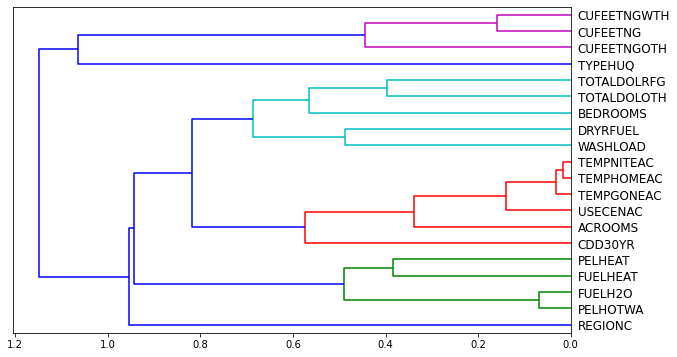

In [17]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

cluster_columns(xs_imp)

Store the re-trained model.

In [18]:
joblib.dump(m, 'model.joblib') 

['model.joblib']

## Interpret the Model and Do Knowledge Discovery

When I plot the feature importances of the trained model, I can clearly see that `TOTALDOLOTH` (Total cost for appliances, electronics, lighting, and miscellaneous uses in whole dollars) is the most important factor for the model to make its decisions.

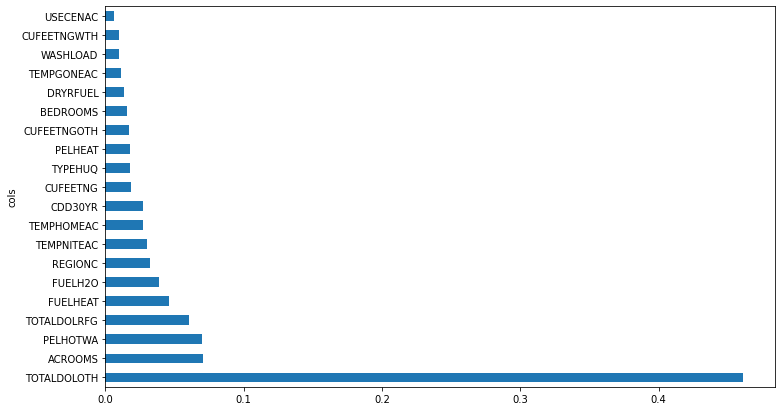

In [19]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(rf_feat_importance(m, xs_imp));

In this section, I make use of the [Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) to interpret the learned function (ML model) and understand how this function makes decisions and predicts house prices for sale.</br></br>The 1D-feature plots show by changing one unit (increase or decrease) of the feature shown in the x-axis, how much the predicted dependent variable (`log KWH`) changes on average.

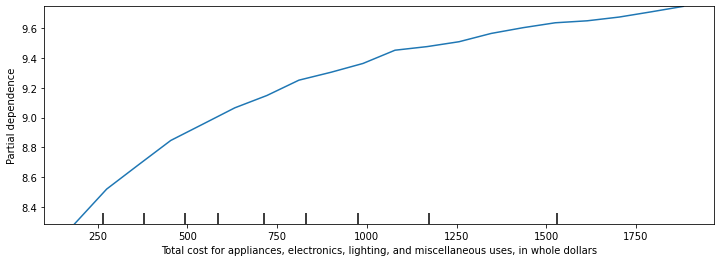

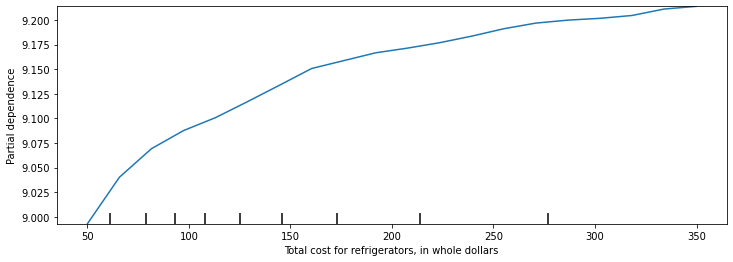

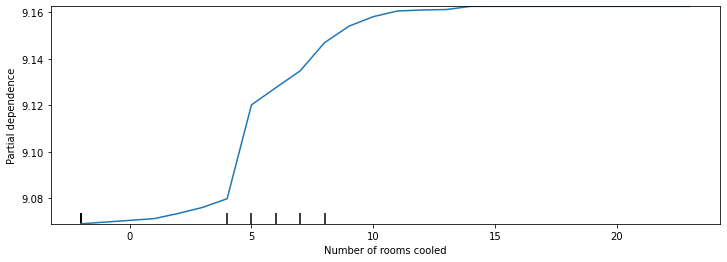

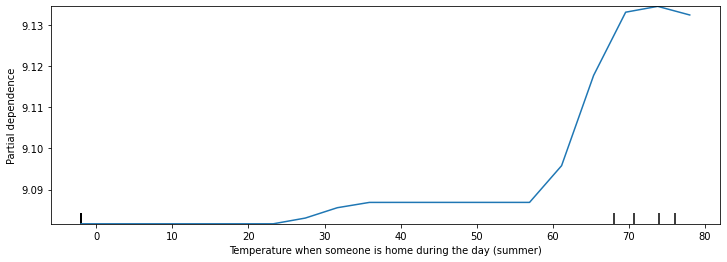

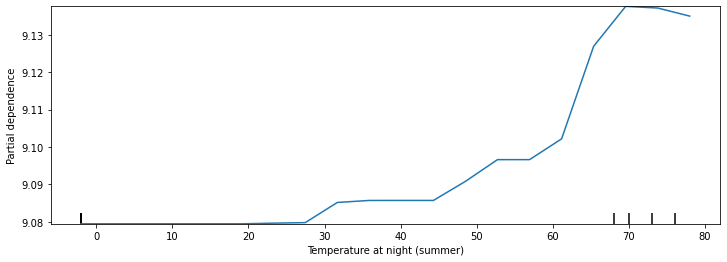

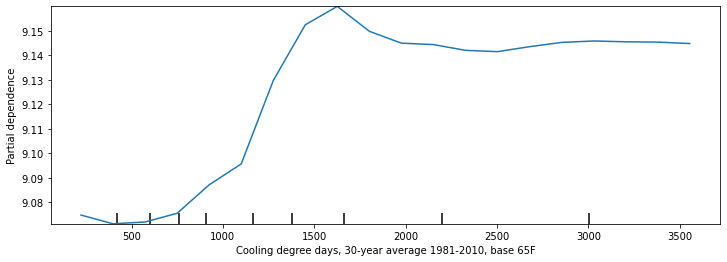

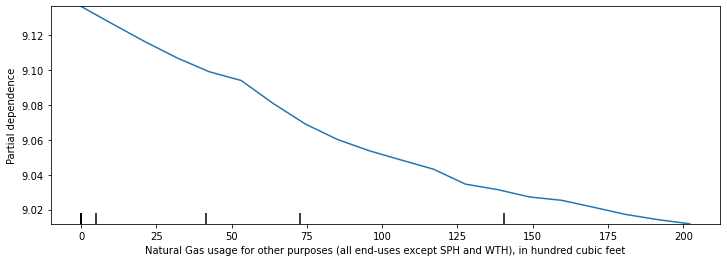

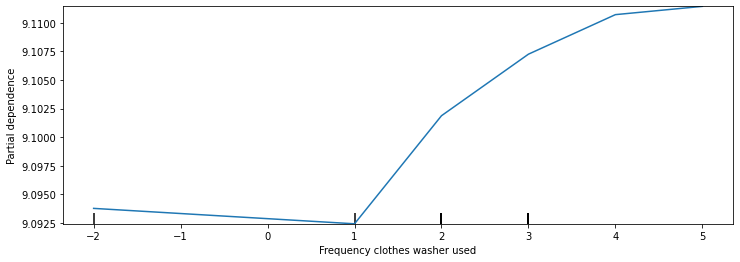

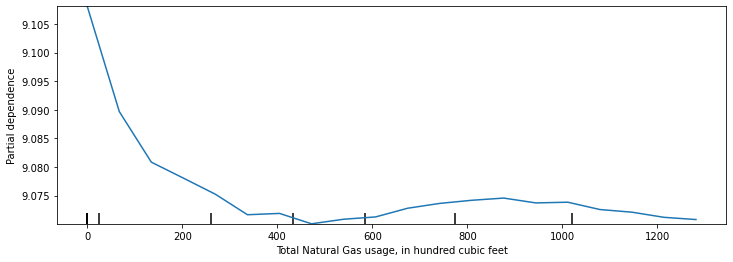

In [20]:
explore_cols = ['TOTALDOLOTH','TOTALDOLRFG','ACROOMS','TEMPHOMEAC','TEMPNITEAC','CDD30YR','CUFEETNGOTH','WASHLOAD','CUFEETNG']

explore_cols_vals = ["Total cost for appliances, electronics, lighting, and miscellaneous uses, in whole dollars",
                     "Total cost for refrigerators, in whole dollars",
                     "Number of rooms cooled",
                     "Temperature when someone is home during the day (summer)",
                     "Temperature at night (summer)",
                     "Cooling degree days, 30-year average 1981-2010, base 65F",
                     "Natural Gas usage for other purposes (all end-uses except SPH and WTH), in hundred cubic feet",
                     "Frequency clothes washer used",
                     "Total Natural Gas usage, in hundred cubic feet"]

for index, col in enumerate(explore_cols):
    fig,ax = plt.subplots(figsize=(12, 4))
    plot_partial_dependence(m, valid_xs_imp, [col], grid_resolution=20, ax=ax);
    x_label = explore_cols_vals[index]
    plt.xlabel(x_label)

The 2D-feature plots show by changing one unit (increase or decrease) of the features shown in the x and y axes, how much the dependent variable changes.
</br>
</br>
Here, the plot shows how much the model (learned function) changes its `log KWH` prediction on average when the two dimensions on the x and y axes change.

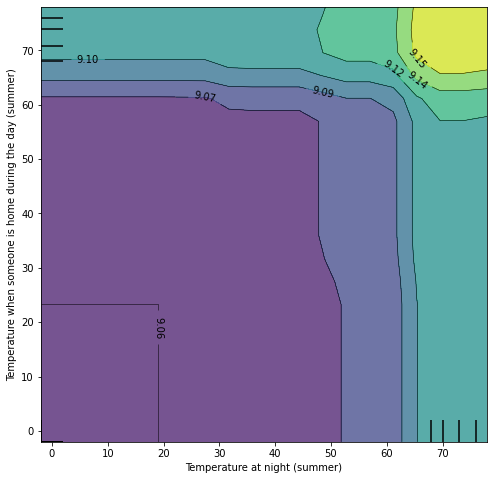

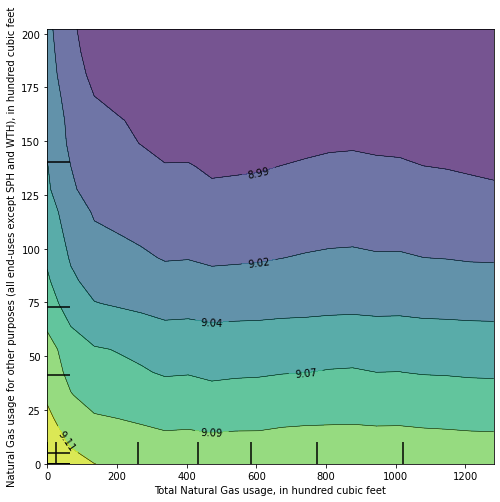

In [21]:
paired_features = [("TEMPNITEAC","TEMPHOMEAC"),("CUFEETNG","CUFEETNGOTH")]
paired_features_vals = [("Temperature at night (summer)","Temperature when someone is home during the day (summer)"),
                        ("Total Natural Gas usage, in hundred cubic feet","Natural Gas usage for other purposes (all end-uses except SPH and WTH), in hundred cubic feet")]


for index, pair in enumerate(paired_features):
  fig,ax = plt.subplots(figsize=(8, 8))
  plot_partial_dependence(m, valid_xs_imp, [pair], grid_resolution=20, ax=ax);
  
  x_label = paired_features_vals[index][0]
  y_label = paired_features_vals[index][1]

  plt.xlabel(x_label)
  plt.ylabel(y_label)

## THE END!